In [75]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [44]:
root_dir = "dataset"

In [55]:
data = []
labels = []

for label in os.listdir(root_dir):
    files = os.listdir(root_dir + "/" + label)
    for file in files:
        file_path = os.path.join(root_dir + "/" + label + "/" + file)
        
        data.append(file_path)
        labels.append(label)

In [56]:
print(len(data))
print(len(labels))

327
327


In [57]:
data = pd.Series(data)
labels = pd.Series(labels)

In [58]:
df = pd.DataFrame({"data": data, "label": labels})

In [60]:
df.shape

(327, 2)

In [61]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=4242)

In [62]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=4242)

In [63]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [65]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="data",
    y_col="label",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
)

valid_gen = test_datagen.flow_from_dataframe(
    valid_df,
    x_col="data",
    y_col="label",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="data",
    y_col="label",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
)

Found 264 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.


In [66]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

43941136/43941136 [==============================] - 4s 0us/step


In [72]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
plot_model(model)

In [81]:
history = model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=10)

/var/folders/k7/w37qytjn78j3258njhbzvlvr0000gn/T/ipykernel_85923/184305253.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=10)


Epoch 1/10
9/9 [==============================] - 13s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.5333
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.5333
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.5333
Epoch 4/10
9/9 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.5333
Epoch 5/10
9/9 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.5333
Epoch 6/10
9/9 [==============================] - 13s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.5333
Epoch 7/10
9/9 [==============================] - 13s 2s/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 -

In [84]:
model.evaluate(test_gen)

2/2 [==============================] - 2s 57ms/step - loss: 0.0000e+00 - accuracy: 0.5152


[0.0, 0.5151515007019043]

In [85]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.0,0.575758,0.0,0.533333
1,0.0,0.575758,0.0,0.533333
2,0.0,0.575758,0.0,0.533333
3,0.0,0.575758,0.0,0.533333
4,0.0,0.575758,0.0,0.533333


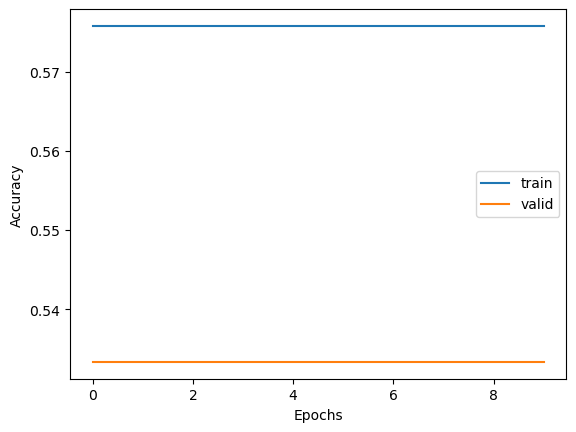

In [94]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

In [ ]:
model.save("alpaca.h5")